In [1]:
import numpy as np
import string
import gensim
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


In [2]:
# Imports the labelled lyrics data, and splits the lyrics from the labels

# Loads in data, and initializes both lyrics and training labels
labelled_lyrics = open("ml_pn_balanced.txt","r", encoding="utf8").readlines()
lyrics = []
yData = []

for example in labelled_lyrics:
    
    if example[0] != ' ':
        lyrics.append(example[2:-2])
        yData.append(int(example[0]))

In [3]:
# Processes lyrics into training data

# Initializes training data, stop words list and translator for stripping punctuation
xData = []
stop_words = set(stopwords.words('english'))
translator = str.maketrans('', '', string.punctuation)

for lyric in lyrics:
    
    # Tokenize each lyric, and set all characters to lower-case
    tokens = word_tokenize(lyric)
    tokens = [word.lower() for word in tokens]
    
    # Remove punctuation
    tokens_nopunc = [word.translate(translator) for word in tokens]
    
    # Remove non-alphabetic tokens
    words = [word for word in tokens_nopunc if word.isalpha()]
    
    # Remove stop words from the lyric
    words = [word for word in words if not word in stop_words]
    
    # Append to training data
    xData.append(words)

In [4]:
# Loads pre-trained GloVe word embeddings

# Load in GloVe file and initialize embedding index
filename = 'glove.6B.100d.txt'
file = open(os.path.join('', filename), encoding = "utf-8")
embeddings_index = {}

for line in file:
    
    # Add each embedding to the embedding index
    embedding = line.split()
    embeddings_index[embedding[0]] = np.asarray(embedding[1:])

file.close()

In [5]:
# Map each word token in the training data to an integer

# For each training example, maps each word token to an integer
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(xData)
xData_seq = tokenizer.texts_to_sequences(xData)

# Pad sequences shorter than max length 
max_num_tokens = max([len(tokenized_lyric) for tokenized_lyric in xData])
xData_seq_padded = pad_sequences(xData_seq, maxlen=max_num_tokens)

In [6]:
# Map GloVe word embeddings to each word in the tokenizer word index to create a matrix of word embeddings

# Initialize embedding matrix
EMBEDDING_DIM = 100
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

# Populate embedding matrix
for word, i in word_index.items():
    
    if i > num_words:
        continue
        
    # Assign corresponding GloVe embedding to the given word
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        # Words not found in the embedding are assigned a zero vector by default
        embedding_matrix[i] = embedding_vector

In [7]:
# Shuffles the data, and splits it into train and test sets

VALIDATION_SPLIT = 0.3

# Shuffles data and labels
word_indices = np.arange(xData_seq_padded.shape[0])
np.random.shuffle(word_indices)
xData_seq_padded = xData_seq_padded[word_indices]
moods = np.array(yData)
moods = moods[word_indices]

# Binarizes the mood labels
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
moods = encoder.fit_transform(moods.tolist())

# Splits the dataset into train and test sets
num_validation_samples = int(VALIDATION_SPLIT * xData_seq_padded.shape[0])
X_train_pad = xData_seq_padded[:-num_validation_samples]
y_train = moods[:-num_validation_samples]

X_test_pad = xData_seq_padded[-num_validation_samples:]
y_test = moods[-num_validation_samples:]

In [12]:
# Defines the Binary model, compiles and trains it

model = Sequential()
embedding_layer = Embedding(num_words, 
                            EMBEDDING_DIM, 
                            embeddings_initializer=Constant(embedding_matrix), 
                            input_length=max_num_tokens,
                            trainable=False)
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Saves a History object for plotting
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=10, validation_data=(X_test_pad, y_test), verbose=2)

Train on 1400 samples, validate on 600 samples
Epoch 1/10
 - 4s - loss: 0.5186 - accuracy: 0.7386 - val_loss: 0.3804 - val_accuracy: 0.8467
Epoch 2/10
 - 4s - loss: 0.2637 - accuracy: 0.8979 - val_loss: 0.2684 - val_accuracy: 0.8850
Epoch 3/10
 - 4s - loss: 0.1702 - accuracy: 0.9314 - val_loss: 0.3038 - val_accuracy: 0.8600
Epoch 4/10
 - 5s - loss: 0.1274 - accuracy: 0.9521 - val_loss: 0.2011 - val_accuracy: 0.9183
Epoch 5/10
 - 5s - loss: 0.0847 - accuracy: 0.9671 - val_loss: 0.1940 - val_accuracy: 0.9250
Epoch 6/10
 - 5s - loss: 0.0612 - accuracy: 0.9800 - val_loss: 0.2333 - val_accuracy: 0.8967
Epoch 7/10
 - 5s - loss: 0.0504 - accuracy: 0.9829 - val_loss: 0.1988 - val_accuracy: 0.9183
Epoch 8/10
 - 5s - loss: 0.0399 - accuracy: 0.9843 - val_loss: 0.1819 - val_accuracy: 0.9317
Epoch 9/10
 - 5s - loss: 0.0324 - accuracy: 0.9871 - val_loss: 0.2038 - val_accuracy: 0.9100
Epoch 10/10
 - 5s - loss: 0.0400 - accuracy: 0.9829 - val_loss: 0.1765 - val_accuracy: 0.9217


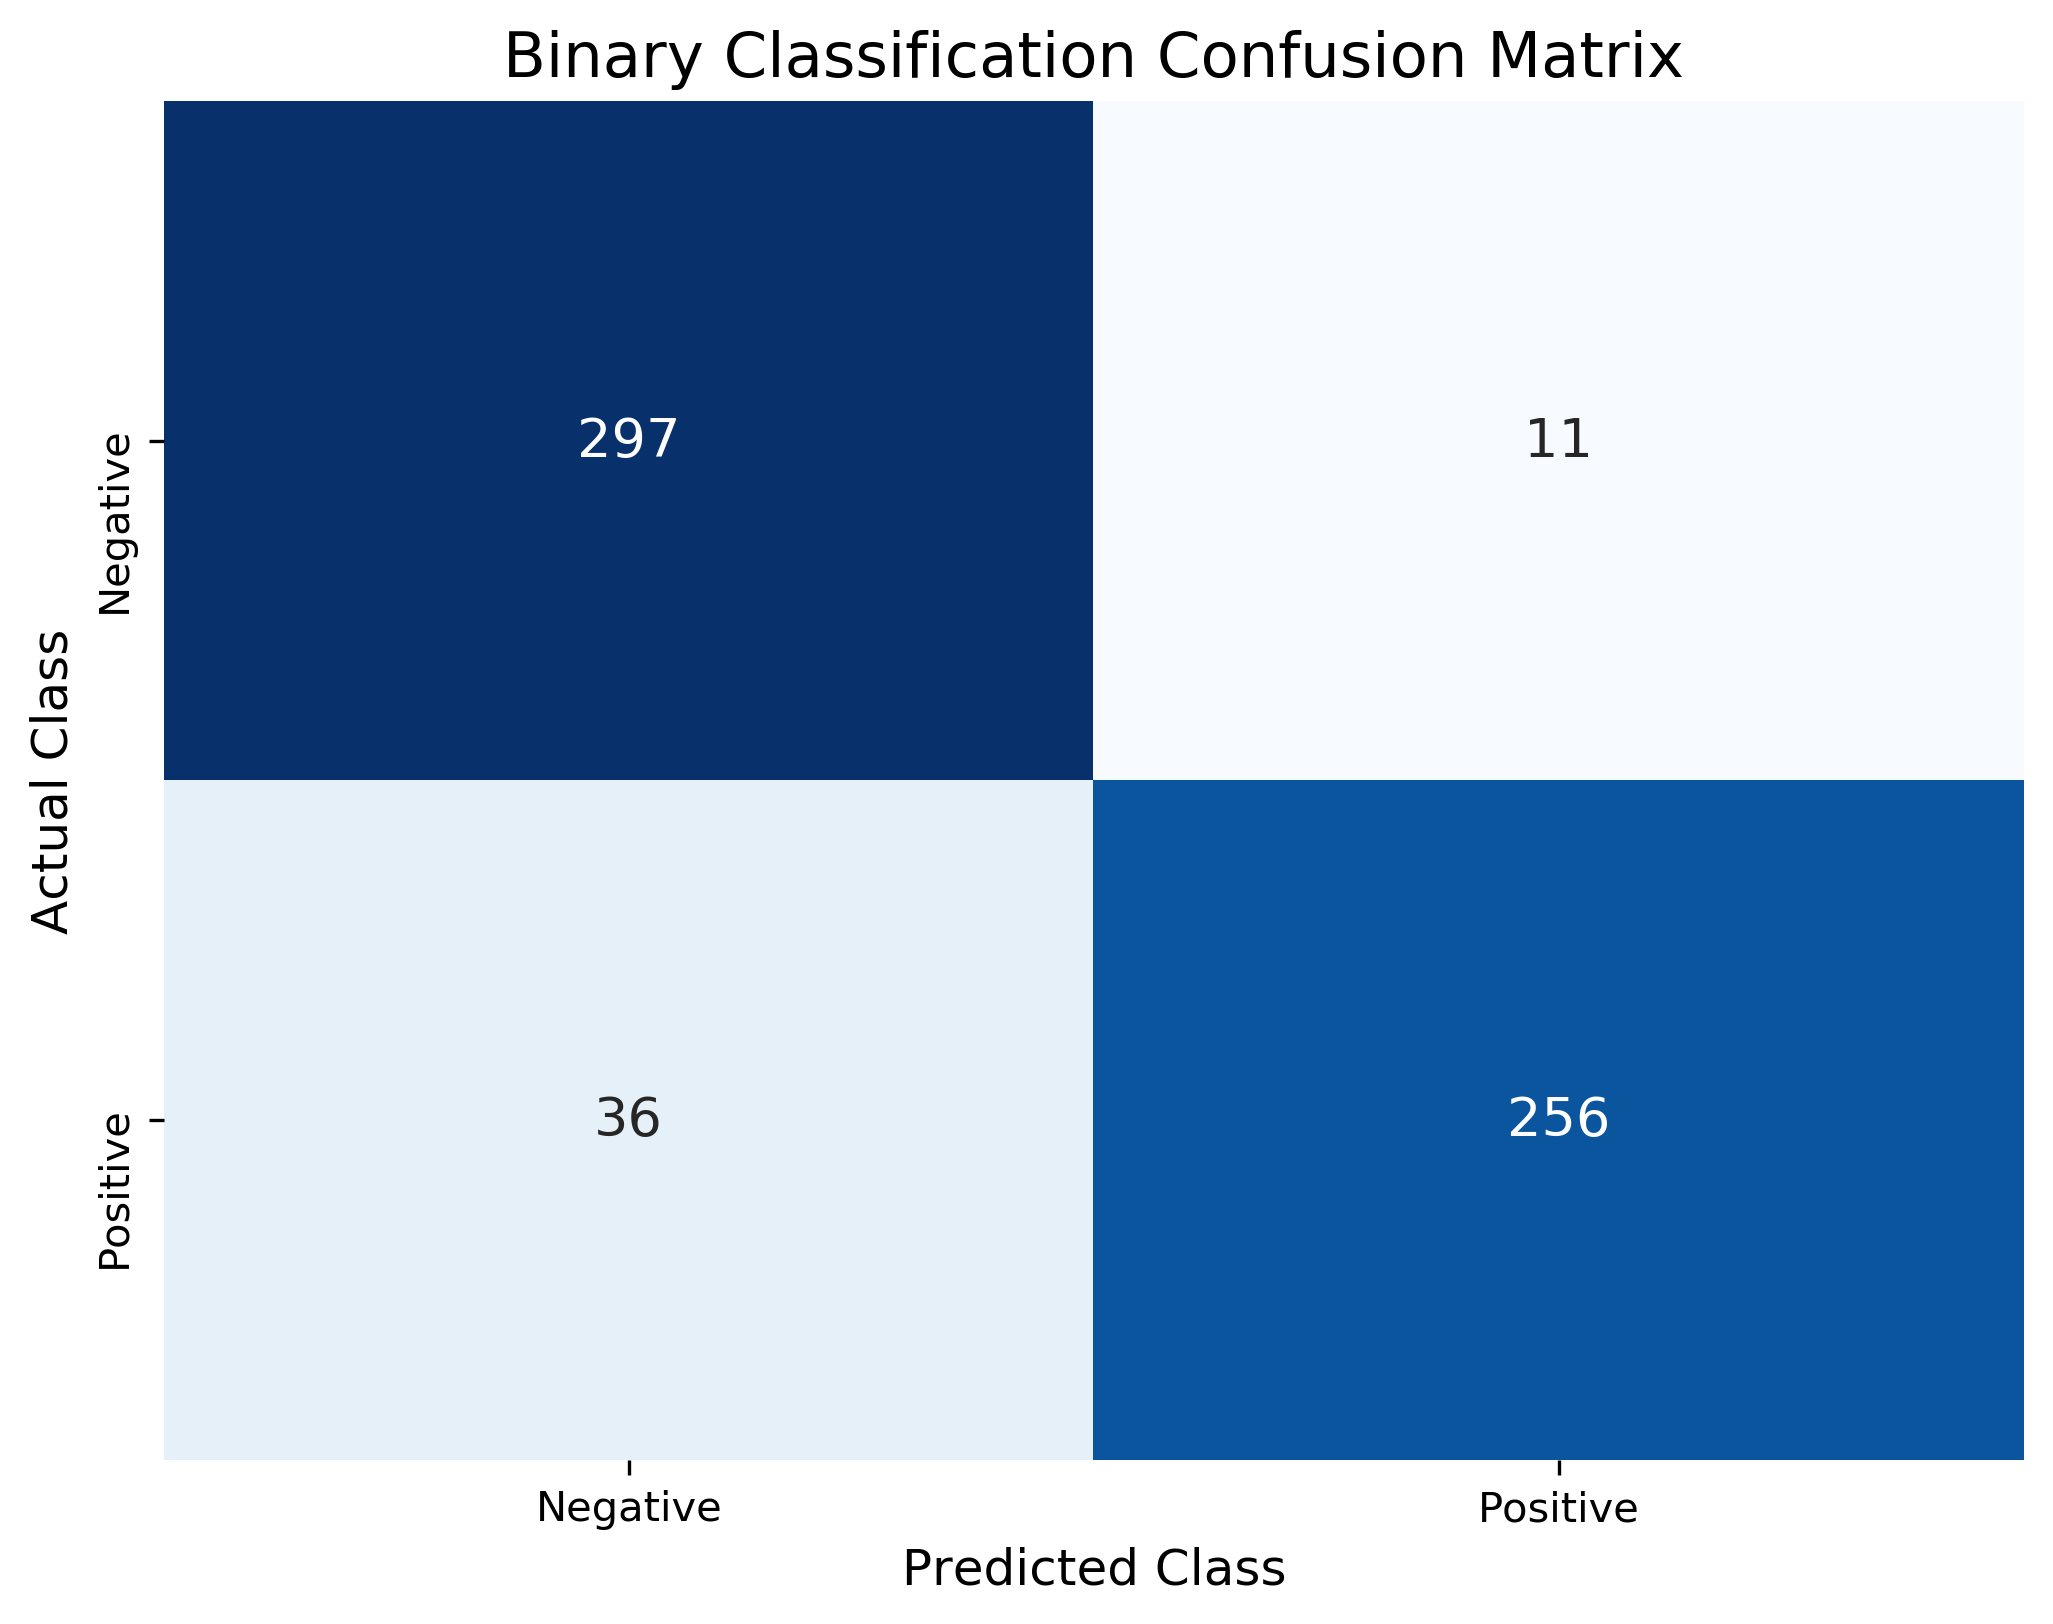

In [13]:
# Plot confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sn
import pandas as pd

# Gets predicted labels from model
y_pred = np.around(model.predict(X_test_pad)).astype(int).flatten()

# Generates confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Formats and displays the confusion matrix
figure(num=None, figsize=(8, 6), dpi=300)
df_cm = pd.DataFrame(cm, index = ['Negative', 'Positive'], columns = ['Negative', 'Positive'])
sn.heatmap(df_cm, annot=True, annot_kws={"size": 13}, cmap=plt.cm.Blues, fmt='g', cbar=False)
plt.title('Binary Classification Confusion Matrix', fontsize=15)
plt.xlabel("Predicted Class", fontsize=12)
plt.ylabel("Actual Class", fontsize=12)
plt.show()

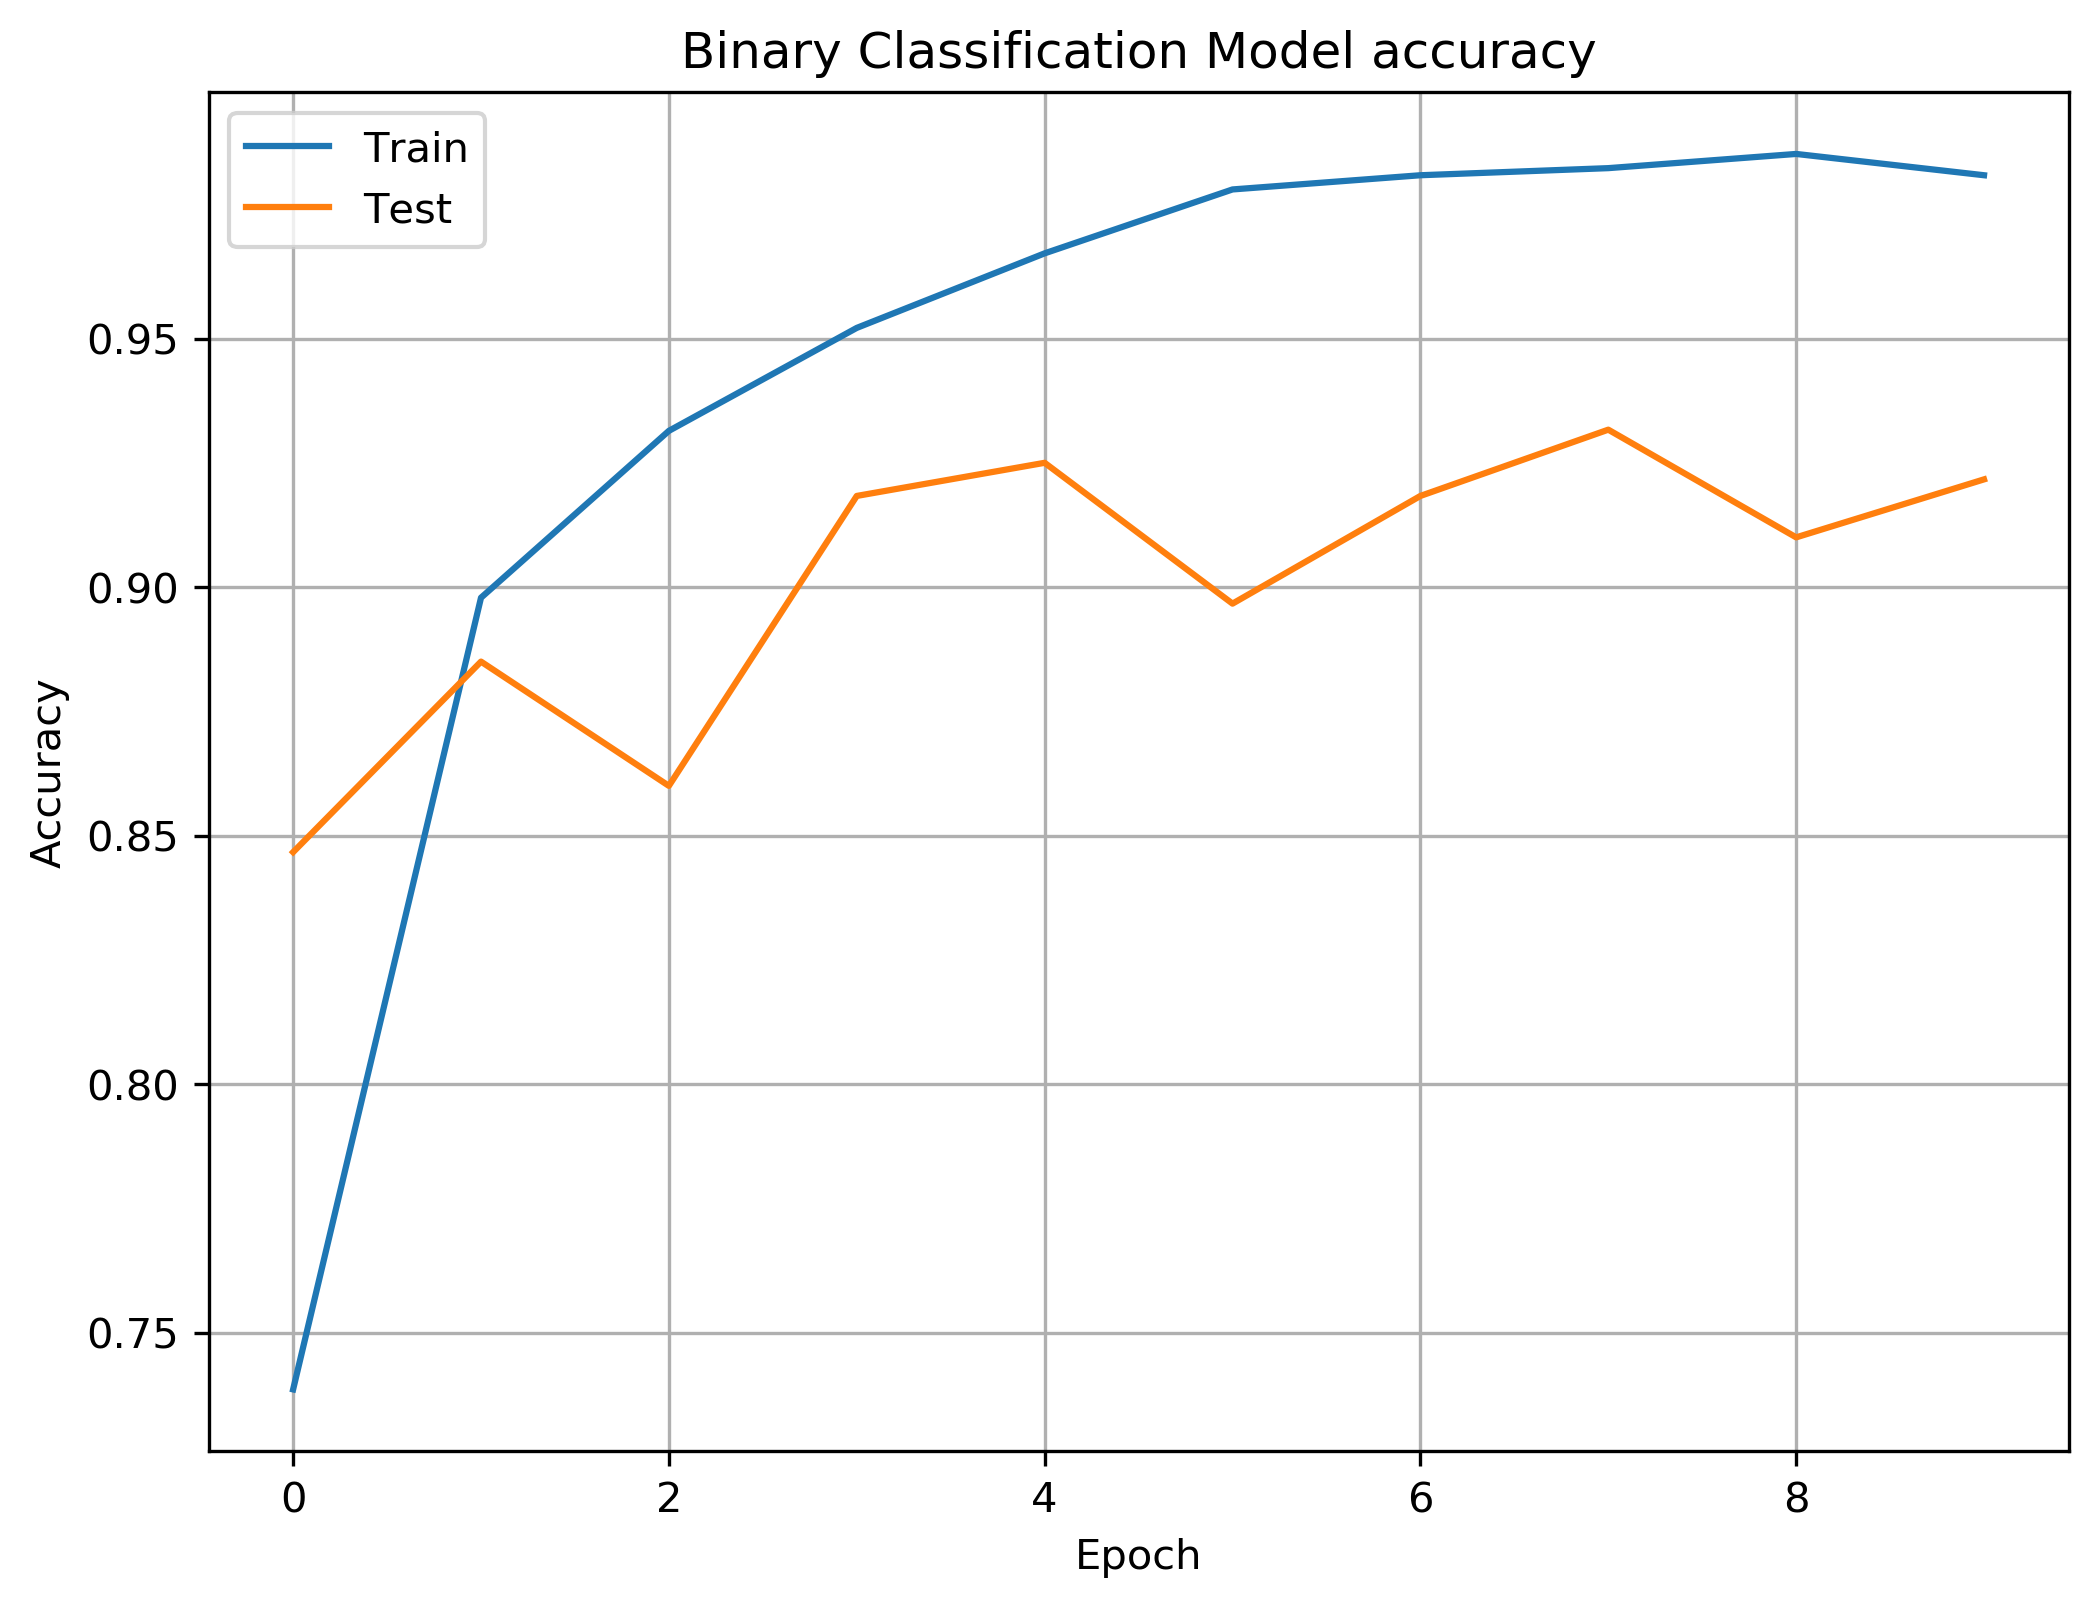

In [14]:
# Plot accuracy as a function of training epoch

figure(num=None, figsize=(8, 6), dpi=300)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid(True)
plt.title('Binary Classification Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
# Calculate the average length of song lyrics

avg = 0
for line in xData:
    avg = avg + len(line) #tokenize
print(avg / 2000)

112.6475
['goes', 'baby', 'ooh', 'girl', 'look', 'nt', 'know', 'good', 'feels', 'call', 'girl', 'goes', 'baby', 'loving', 'everything', 'ooh', 'girl', 'look', 'bet', 'ai', 'nt', 'know', 'checking', 'putting', 'heels', 'swear', 'body', 'perfect', 'baby', 'work', 'baby', 'yeah', 'love', 'way', 'poking', 'girl', 'give', 'something', 'feel', 'please', 'believe', 'gone', 'twerking', 'end', 'night', 'baby', 'waiting', 'day', 'wrap', 'hands', 'around', 'waist', 'kiss', 'face', 'would', 'nt', 'trade', 'feeling', 'nothing', 'even', 'minute', 'sit', 'long', 'takes', 'get', 'alone', 'soon', 'come', 'walking', 'way', 'gon', 'hear', 'say', 'goes', 'baby', 'ooh', 'girl', 'look', 'nt', 'know', 'good', 'feels', 'call', 'girl', 'goes', 'baby', 'loving', 'everything', 'ooh', 'girl', 'look', 'get', 'chills', 'whenever', 'see', 'face', 'place', 'girl', 'feel', 'like', 'movie', 'baby', 'like', 'oowee', 'baby', 'oh', 'like', 'waterfalls', 'hair', 'falls', 'waist', 'get', 'taste', 'girl', 'need', 'keep', 'ba